In [43]:
import math
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy as sp
import geopandas as gpd

In [58]:
elects = pd.read_csv("../data/TX_statewide_18_Dem_Runofff.csv").drop(columns=["Unnamed: 0"])
tx_prec_shapes = gpd.read_file("../data/TX_VTDs_cvap/TX_VTDs_cvap.shp")
dallas_county_pcts = pd.merge(left=tx_prec_shapes, right=elects, on="CNTYVTD").query("CNTY == 113")

In [61]:
dallas_runs_noised = pd.read_csv("dallas_pcts/toydown_dallas_county_prec_runs.csv")

In [63]:
dallas_county_pcts = pd.merge(left=dallas_county_pcts, right=dallas_runs_noised, on="CNTYVTD")

In [128]:
def plot_er_graph(data, cand, race, elect, tot_vote, eps, split,
                  filt=True, n_samps=32, ax=None, title=True, plot_cvap=False):
    
    df = data.query("epsilon == @eps & split == @split")
    df = df.query("`{}` > 10".format(tot_vote)) if filt else df
    xp = np.linspace(0, 1, 100)
    perc_race = df["{}_pct".format(race)].fillna(0) #(df.HVAP10 / df.VAP10).fillna(0)
    perc_cand = df["{}D_18R_Governor_pct".format(cand)].fillna(0) #(df[cand_col] / sum([df[c] for c in elect_cols])).fillna(0)
    line = sp.stats.linregress(perc_race, perc_cand)
    l = np.poly1d([line.slope, line.intercept])

    ms = np.zeros(n_samps)
    rs = np.zeros(n_samps)

    if ax==None:
        fig = plt.figure(figsize=(8,6))
        ax = fig.add_subplot(1, 1, 1)
    if title: ax.set_title("ER - Votes for {}: {}".format(cand, elect))
    ax.set_xlim(-0.05,1.05)
    ax.set_ylim(-0.05,1.05)

    for i in range(n_samps):
        perc_race_noised = (df["{}_{}_noise".format(i, race)] / df["{}_VAP_noise".format(i)]).fillna(0)
            
        line_noised = sp.stats.linregress(perc_race_noised, perc_cand)
        ln = np.poly1d([line_noised.slope, line_noised.intercept])
        ms[i] = line_noised.slope
        rs[i] = line_noised.rvalue
        ax.plot(perc_race_noised, perc_cand, '.', color="lightcoral")
        ax.plot(xp, ln(xp), '-', color="red")
    
    ax.plot(perc_race, perc_cand, '.', color="b")
    ax.plot(xp, l(xp), '-', color="b", 
             label="m: {}".format(round(line.slope, 3)))
    ax.plot([], [], '-', color="r", 
             label="E(m): {}, Var(m): {}".format(round(np.mean(ms),3), round(np.var(ms),4)))  
    
    ax.legend()
    ax.set_xlabel("% {}".format(race))
    ax.set_ylabel("{} % of Voters".format(cand))
    return ax

In [131]:
def plot_elect_grid(epsilon_values, epsilon_splits, data, candidate, race, election, 
                    tot_vote, figsize=(10,10), filt=True, title=True):
    
    fig, axs = plt.subplots(len(epsilon_values),len(epsilon_splits), figsize=figsize)

    if title: fig.suptitle("ER - Votes for {}: {}".format(candidate, election))
    plt.subplots_adjust(hspace = 0.25)

    for i in range(len(epsilon_values)):
        for j in range(len(epsilon_splits)):
            plot_er_graph(data, candidate, race, election, tot_vote, 
                          epsilon_values[i], epsilon_splits[j], 
                          title=False, ax=axs[i,j], filt=filt)

    pad = 5
    for ax, row in zip(axs[:,0], ["$\epsilon$ = {}".format(eps) for eps in epsilon_values]):
        ax.annotate(row, xy=(0, 0.5), xytext=(-ax.yaxis.labelpad - pad, 0),
                    xycoords=ax.yaxis.label, textcoords='offset points',
                    size='large', ha='right', va='center')

    for ax, col in zip(axs[0], ["Split: {}".format(s) for s in epsilon_splits]):
        ax.annotate(col, xy=(0.5, 1), xytext=(0, ax.xaxis.labelpad + pad),
                    xycoords='axes fraction', textcoords='offset points',
                    size='large', ha='center', va='baseline')
        
    return fig, axs

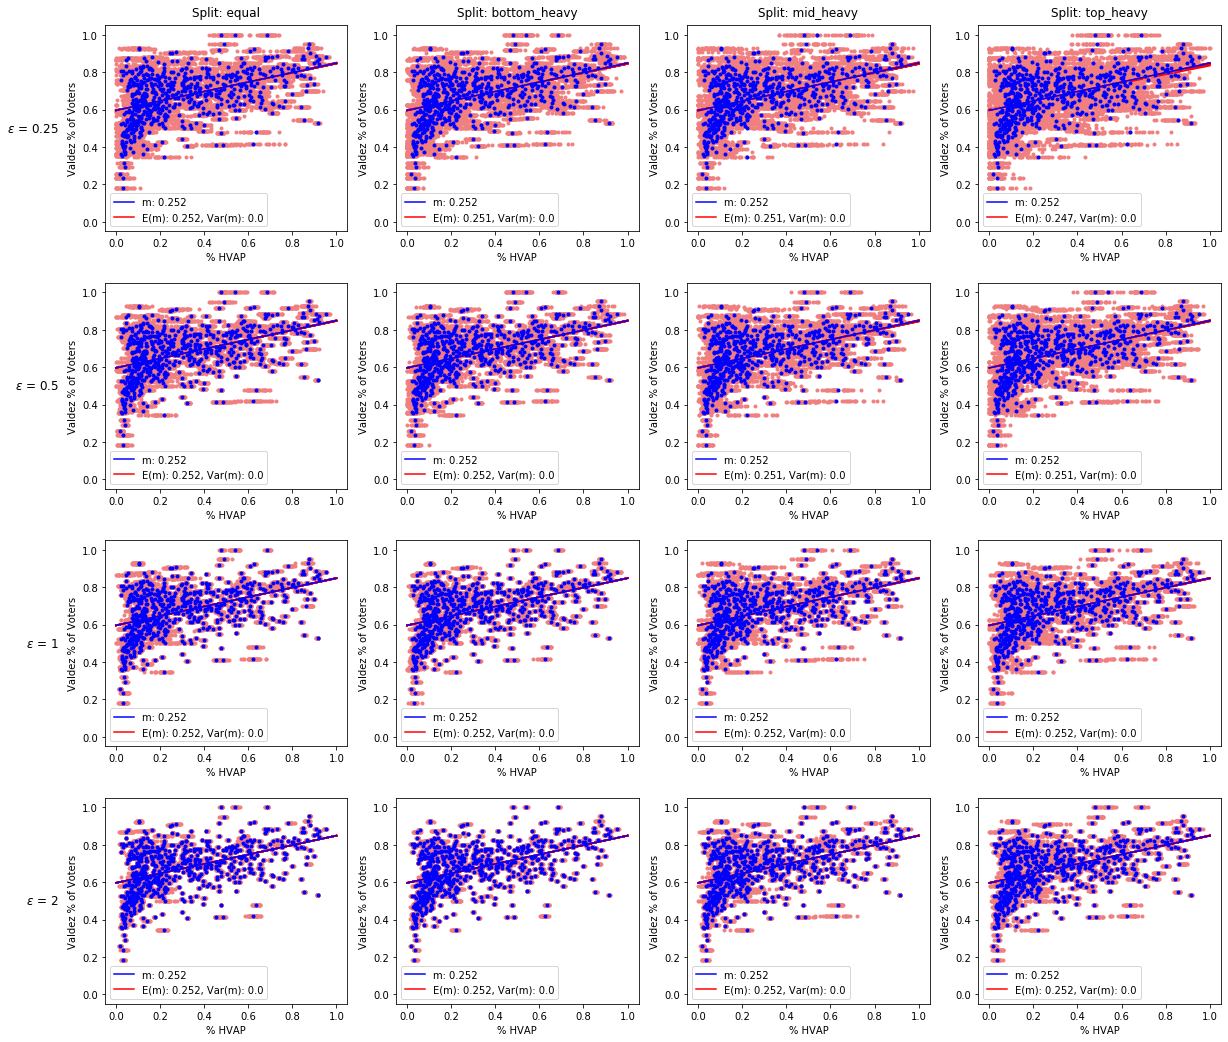

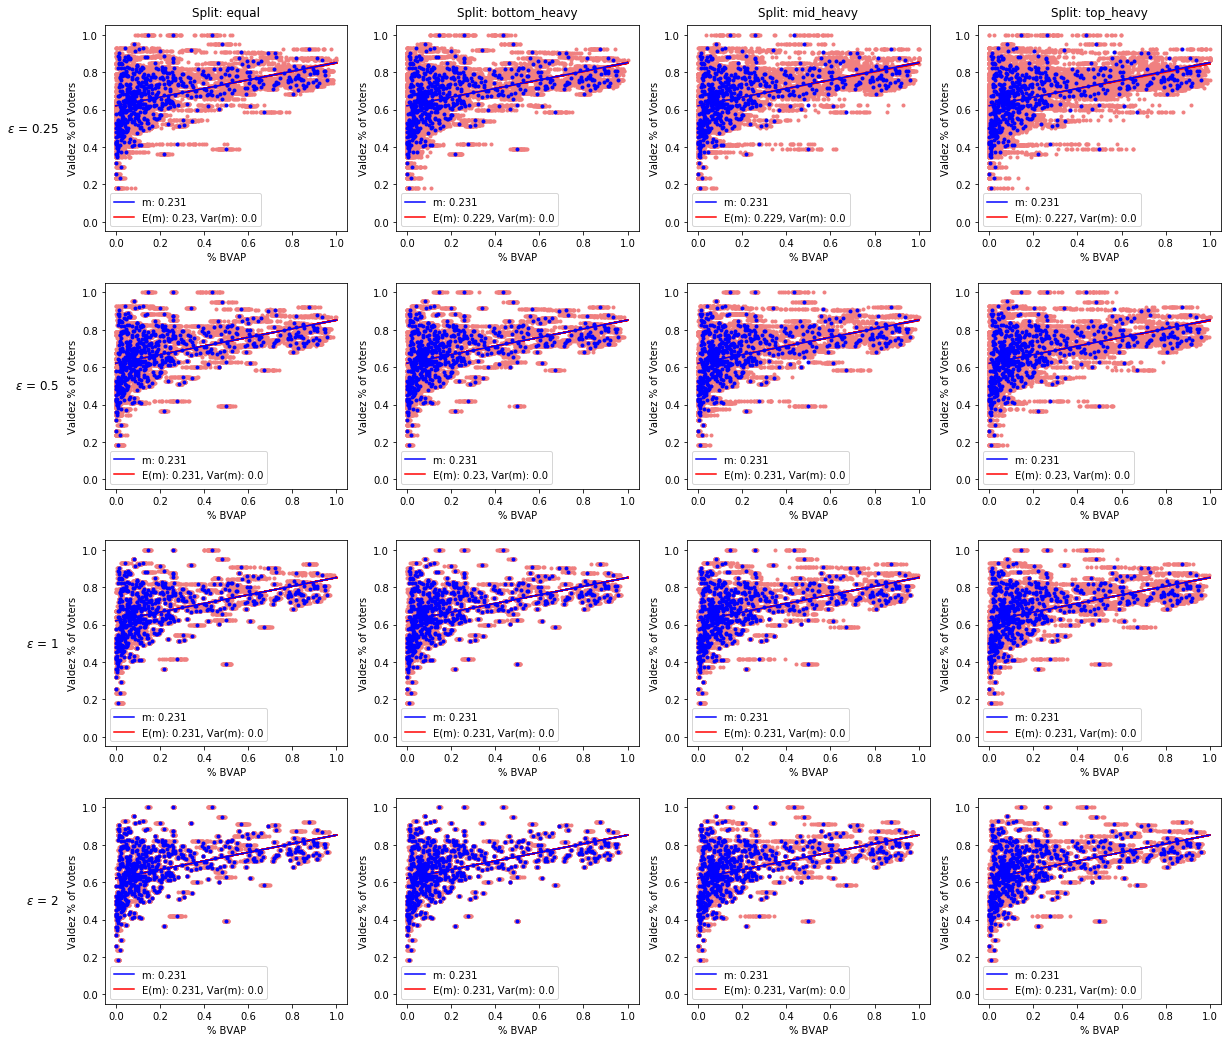

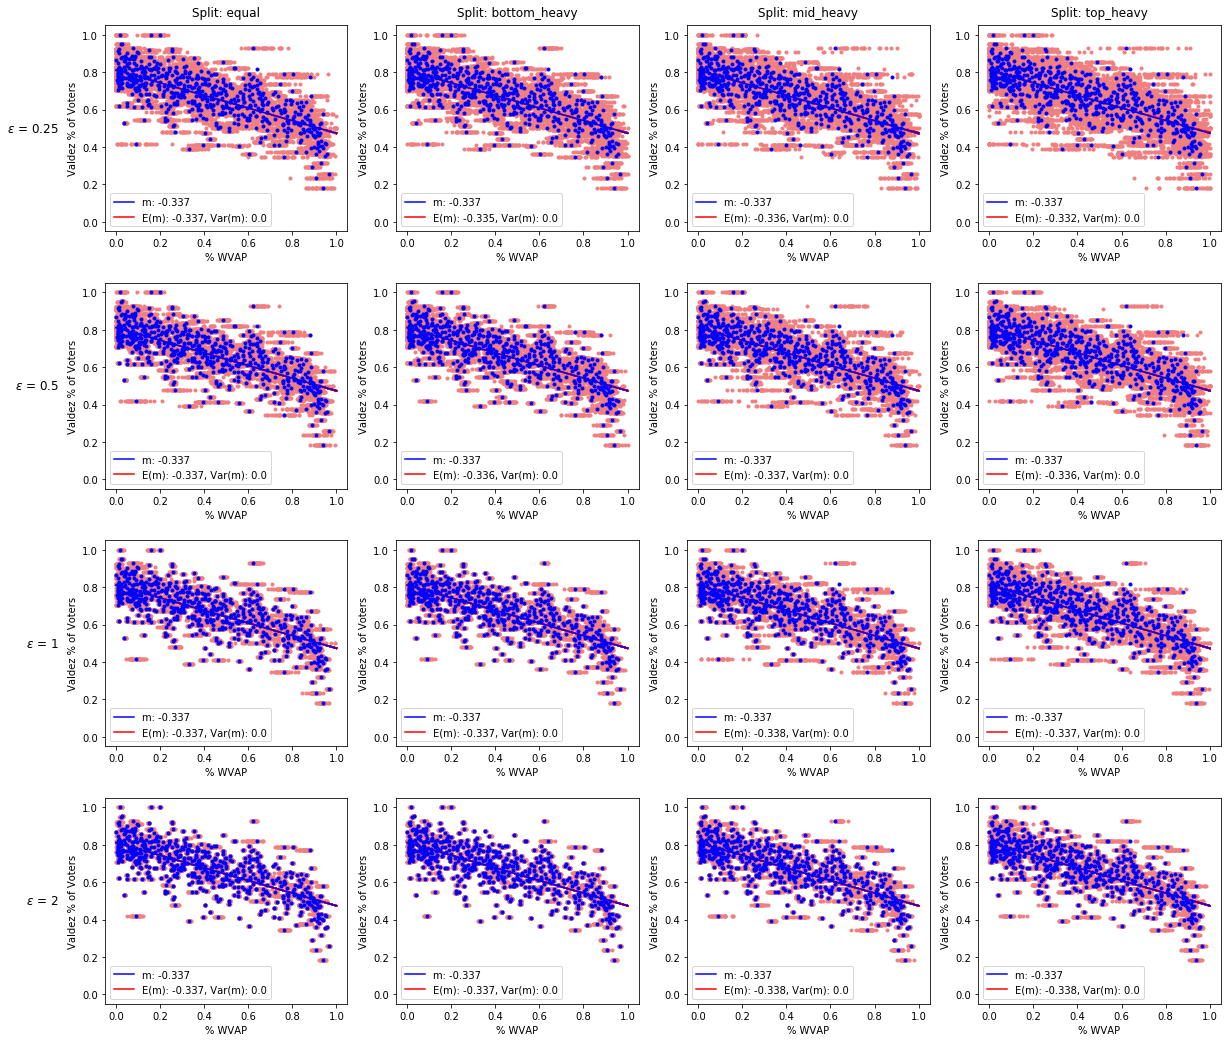

In [132]:
epsilon_values = [0.25, 0.5, 1, 2]
epsilon_splits = ["equal","bottom_heavy", "mid_heavy", "top_heavy",]
data = dallas_county_pcts
candidate = "Valdez"
election = "TX Statewide 2018 Dem Runofff Govenor"
tot_vote = "18R_Governor_D_tot"

for race in ["HVAP", "BVAP", "WVAP"]:
    fig, axs = plot_elect_grid(epsilon_values, epsilon_splits, data, candidate, race, election, 
                               tot_vote, figsize=(20,18), title=False)
    plt.savefig("plots/ER_{}_{}_{}_elect_param_grid.png".format(candidate, 
                                                                election.replace(',', "").replace(' ', '_'),
                                                                race),
                dpi=200, bbox_inches="tight")

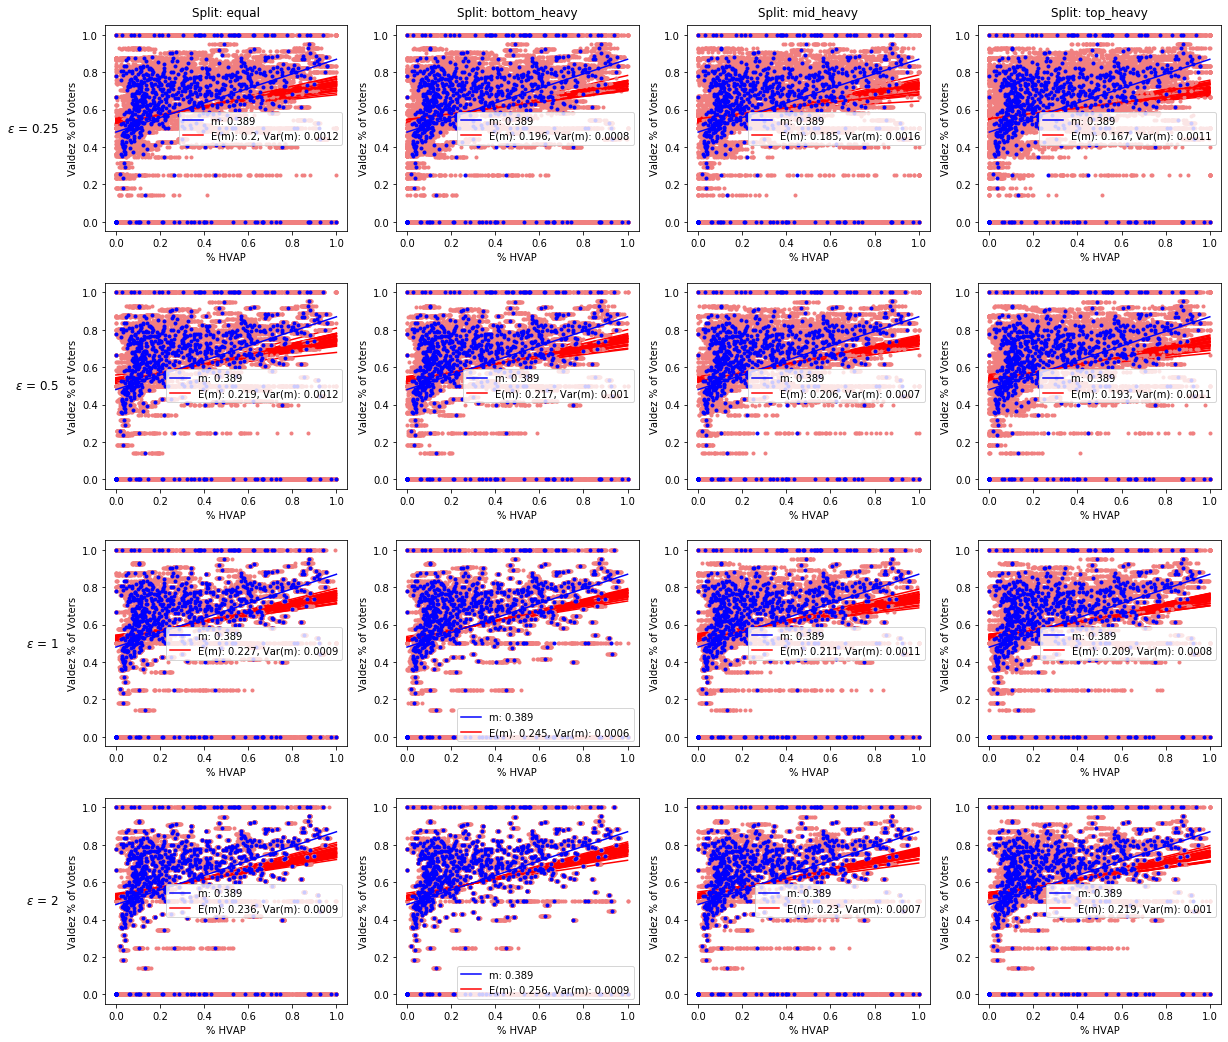

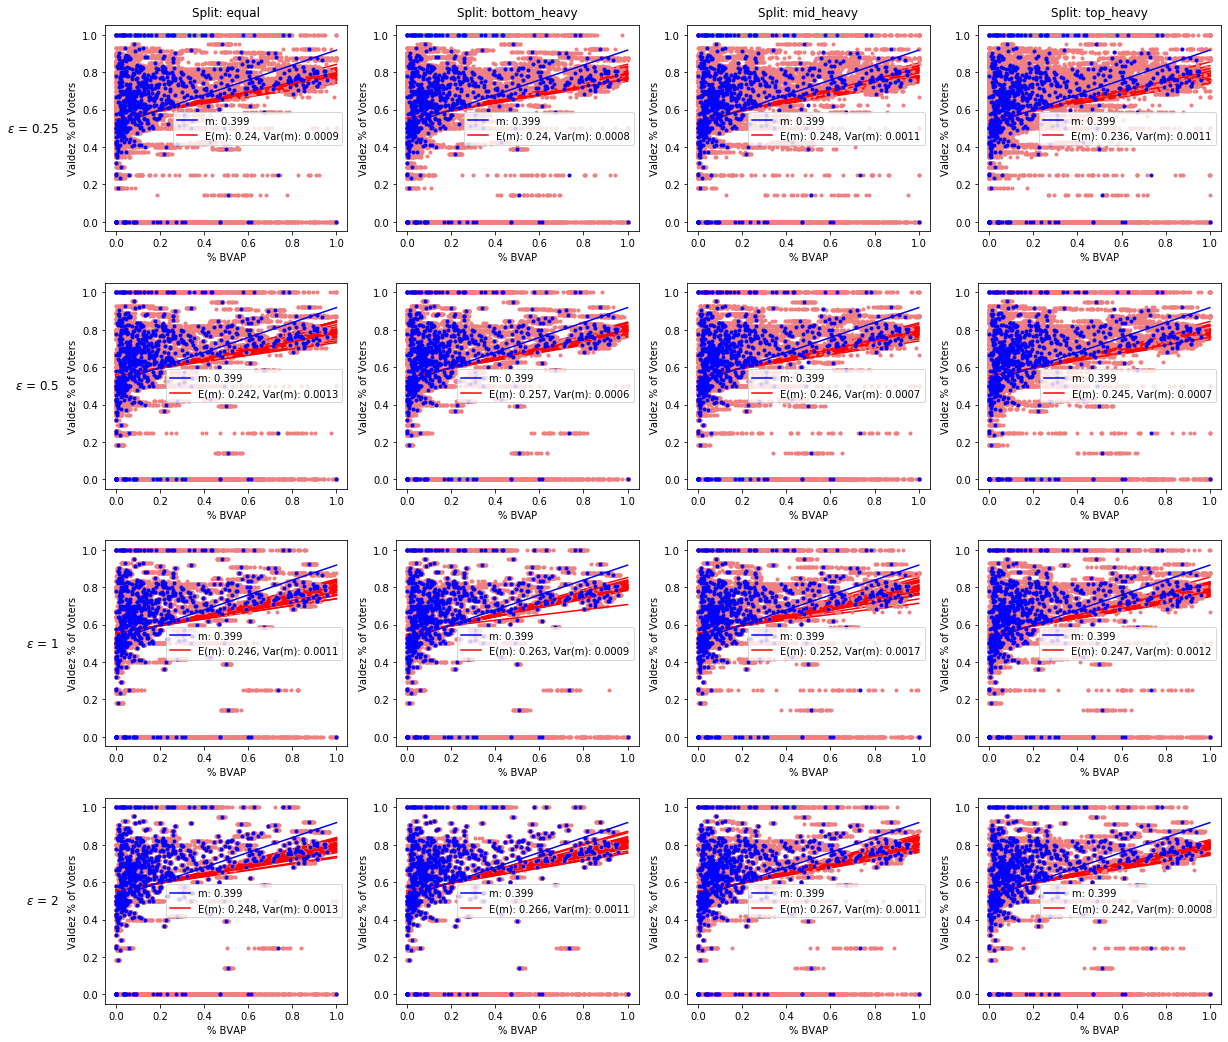

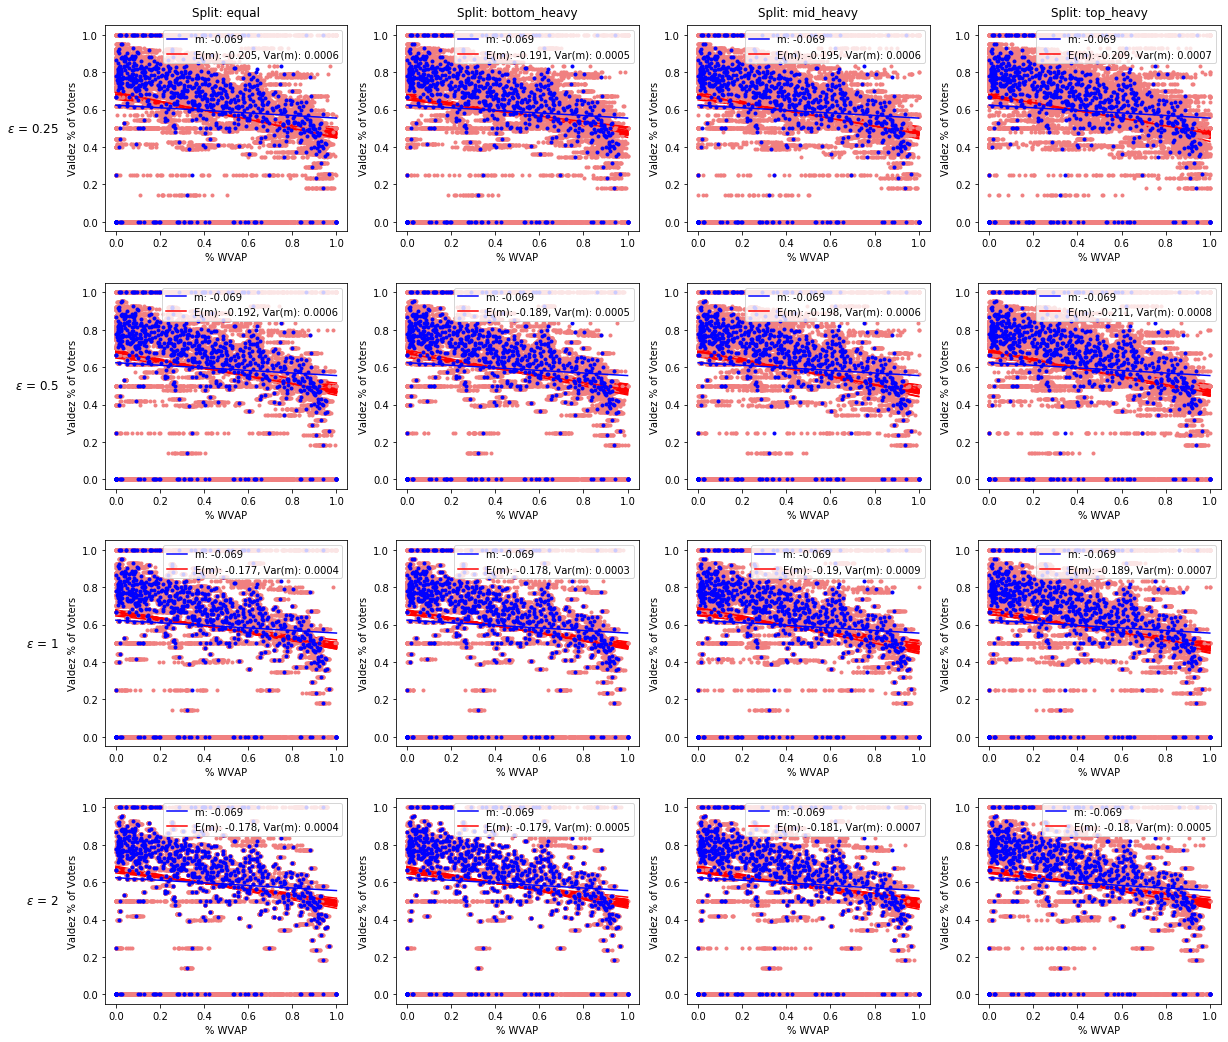

In [133]:
for race in ["HVAP", "BVAP", "WVAP"]:
    fig, axs = plot_elect_grid(epsilon_values, epsilon_splits, data, candidate, race, election, 
                               tot_vote, figsize=(20,18), title=False, filt=False)
    plt.savefig("plots/ER_{}_{}_{}_elect_param_grid_no_filt.png".format(candidate, 
                                                                election.replace(',', "").replace(' ', '_'),
                                                                race),
                dpi=200, bbox_inches="tight")

In [127]:
dallas_county_pcts.query("epsilon == 1 & split == 'equal'")

,CNTY,COLOR,VTD,CNTYVTD,VTDKEY,Shape_area,Shape_len,CVAP,WCVAP,BCVAP,...,24_WVAP_noise,25_WVAP_noise,26_WVAP_noise,27_WVAP_noise,28_WVAP_noise,29_WVAP_noise,30_WVAP_noise,31_WVAP_noise,epsilon,split
8,113,7,1000,1131000,1927,6.761341e+05,4118.312652,1467.683316,441.057386,689.086079,...,290.489034,274.351170,271.760277,292.366671,282.616721,263.080363,259.475201,284.899967,1.0,equal
24,113,2,1001,1131001,1928,5.855244e+05,4530.621487,1225.000000,475.000000,495.000000,...,300.954562,311.197934,316.944479,304.430501,306.191531,308.034397,301.783162,298.310161,1.0,equal
40,113,7,1002,1131002,1929,3.210395e+05,2521.697962,1364.293882,442.192682,539.931389,...,542.849556,545.647907,539.606046,565.412378,545.926951,531.884325,539.916265,568.507567,1.0,equal
56,113,1,1003,1131003,1930,3.262490e+06,7187.951829,4815.927730,1164.579781,3060.552172,...,702.469561,703.333551,707.148342,704.885352,704.982110,700.597358,704.415079,702.350553,1.0,equal
72,113,2,1004,1131004,1931,1.525565e+06,5090.396582,1695.000000,1000.000000,500.000000,...,1075.064457,1076.079807,1073.973117,1065.471395,1066.445858,1078.606740,1063.391579,1079.189934,1.0,equal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13160,113,6,4660,1134660,2749,2.783417e+04,803.184602,46.200000,23.100000,3.000000,...,25.490268,22.732331,16.076661,18.948215,16.582652,15.366739,20.727562,24.909561,1.0,equal
13176,113,7,4661,1134661,2750,8.643771e+05,4995.329028,1059.576037,176.273533,31.135397,...,276.963390,313.006734,294.259659,302.833410,298.987897,297.775857,312.128567,317.895150,1.0,equal
13192,113,7,4662,1134662,2751,7.654477e+05,5232.112632,470.536116,251.966507,16.385306,...,146.876829,156.314838,127.842869,133.372981,141.441888,136.427218,144.095786,134.058851,1.0,equal
13208,113,5,4663,1134663,2752,2.183690e+06,6705.199015,0.000000,0.000000,0.000000,...,8.437478,2.709203,9.316074,15.486710,8.780523,15.213623,16.211147,5.548943,1.0,equal


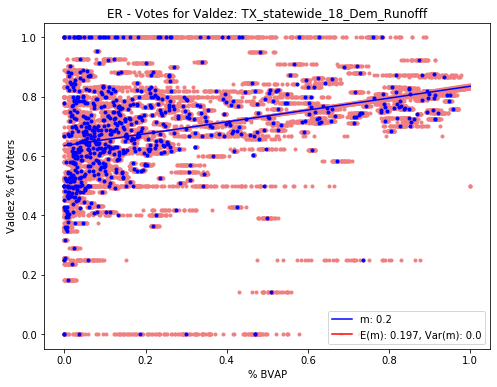

In [94]:
plot_er_graph(dallas_county_pcts, "Valdez", "BVAP", "TX_statewide_18_Dem_Runofff",
              "18R_Governor_D_tot", 2, "top_heavy")
plt.show()

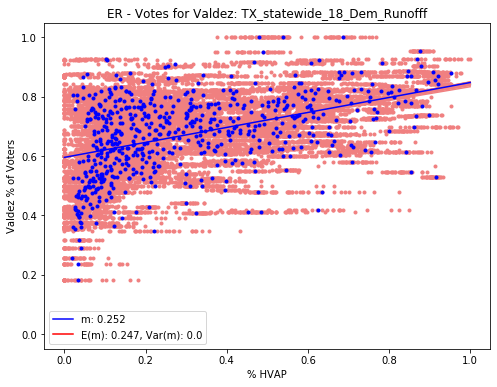

In [85]:
plot_er_graph(dallas_county_pcts, "Valdez", "HVAP", "TX_statewide_18_Dem_Runofff",
              "18R_Governor_D_tot", 0.25, "top_heavy")
plt.show()

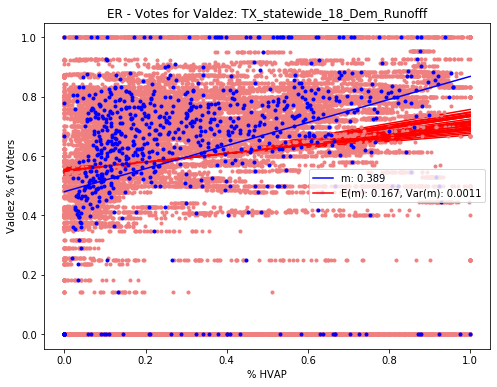

In [134]:
plot_er_graph(dallas_county_pcts, "Valdez", "HVAP", "TX_statewide_18_Dem_Runofff",
              "18R_Governor_D_tot", 0.25, "top_heavy", filt=False)
plt.show()

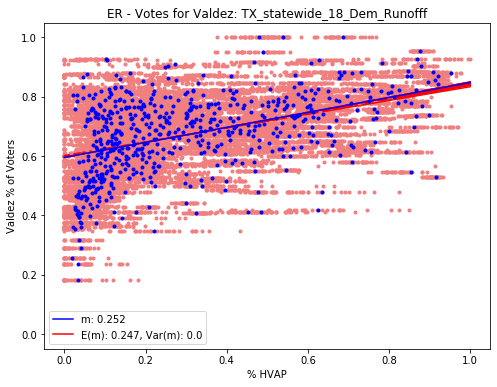

In [135]:
plot_er_graph(dallas_county_pcts, "Valdez", "HVAP", "TX_statewide_18_Dem_Runofff",
              "18R_Governor_D_tot", 0.25, "top_heavy", filt=True)
plt.show()

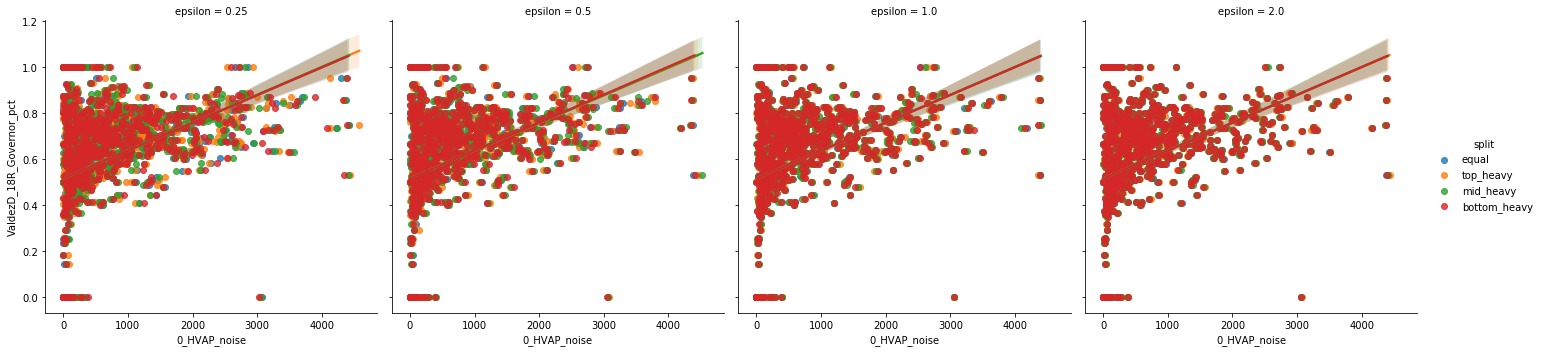

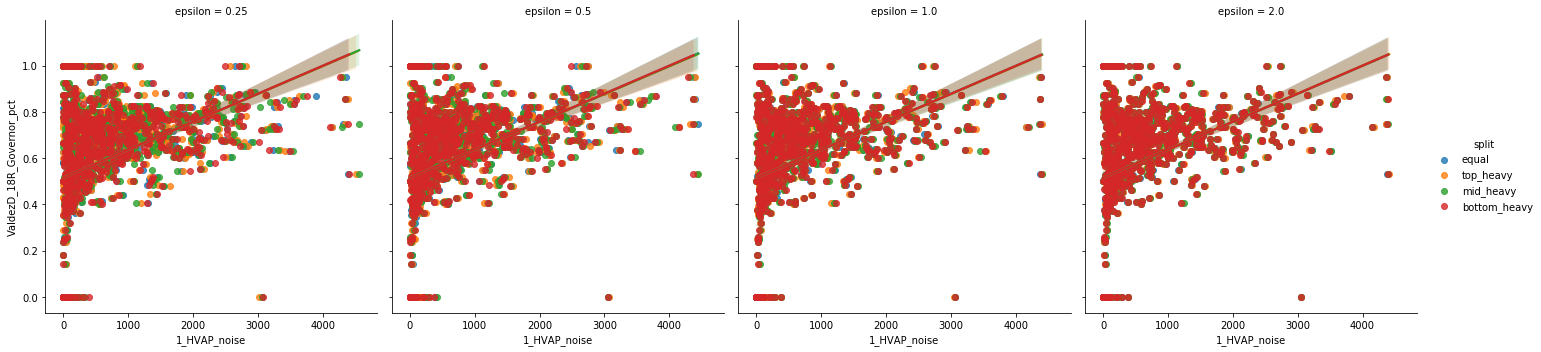

In [162]:
sns.lmplot(data=dallas_county_pcts, hue="split", col="epsilon", 
           x="0_HVAP_noise", y="ValdezD_18R_Governor_pct")
sns.lmplot(data=dallas_county_pcts, hue="split", col="epsilon", 
           x="1_HVAP_noise", y="ValdezD_18R_Governor_pct")

TypeError: inner() got multiple values for argument 'ax'

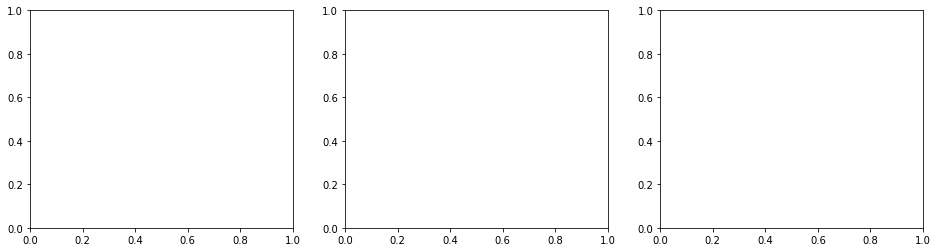

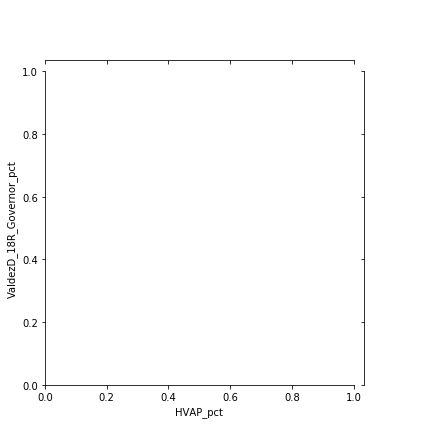

In [137]:
fig, axs = plt.subplots(1,3, figsize=(16,4))

sns.jointplot(data=dallas_county_pcts.query("`18R_Governor_D_tot` >= 10"), 
                x="HVAP_pct", y="ValdezD_18R_Governor_pct", ax=axs[0])

sns.jointplot(data=dallas_county_pcts.query("`18R_Governor_D_tot` >= 10"), 
                x="BVAP_pct", y="ValdezD_18R_Governor_pct", ax=axs[1])

sns.jointplot(data=dallas_county_pcts.query("`18R_Governor_D_tot` >= 10"), 
                x="WVAP_pct", y="ValdezD_18R_Governor_pct", ax=axs[2])

plt.show()

In [170]:
dallas_county_pcts["HVAP_pct"] - (dallas_county_pcts["0_HVAP_noise"] / dallas_county_pcts["0_VAP_noise"])

0        0.004223
1       -0.003346
2       -0.014692
3       -0.021913
4       -0.019563
           ...   
13227   -0.007874
13228   -0.003732
13229   -0.005096
13230   -0.000261
13231    0.004405
Length: 13232, dtype: float64

In [180]:
noised_hvap_perc = np.array([dallas_county_pcts["{}_HVAP_noise".format(i)] / dallas_county_pcts["{}_VAP_noise".format(i)] for i in range(32)])

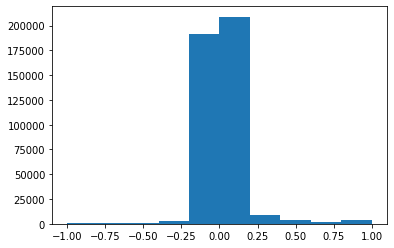

In [192]:
plt.hist(np.array([noised_hvap_perc[i] - dallas_county_pcts["HVAP_pct"] for i in range(32)]).flatten())
plt.show()

In [183]:
dallas_county_pcts["HVAP_pct"]

0        0.467443
1        0.467443
2        0.467443
3        0.467443
4        0.467443
           ...   
13227    0.101145
13228    0.101145
13229    0.101145
13230    0.101145
13231    0.101145
Name: HVAP_pct, Length: 13232, dtype: float64